In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ASTForAudioClassification, AutoProcessor
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import json
from datetime import datetime



In [4]:
Ravdess = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/"
Crema   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/"
Tess    = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/"
Savee   = "/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/"

In [ ]:
ravdess_directory_list = [d for d in os.listdir(Ravdess) if d.startswith("Actor_")]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue  
        
        part = file.split('.')[0].split('-')
        
        if len(part) != 7:
            print(f"⚠️ Skipping malformed file: {file}")
            continue
        
        try:
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_folder, file))
        except ValueError:
            print(f"❌ Couldn't parse emotion code in: {file}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].map(emotion_labels)

print(Ravdess_df.head())
print(Ravdess_df["Path"].values[1])

  Emotions                                               Path
0  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3  neutral  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4     calm  /mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
/mnt/c/Users/rubom/Desktop/Emotions DataSets/Ravdess/Actor_01/03-01-01-01-01-02-01.wav


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Crema/AudioWAV/1001_DFA_DIS_XX.wav


In [ ]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/"+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df['Path'].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df["Path"].values[1])

/mnt/c/Users/rubom/Desktop/Emotions DataSets/Savee/ALL/DC_a02.wav


In [9]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
1,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
2,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
3,neutral,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
4,calm,/mnt/c/Users/rubom/Desktop/Emotions DataSets/R...
...,...,...
475,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
476,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
477,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...
478,surprise,/mnt/c/Users/rubom/Desktop/Emotions DataSets/S...


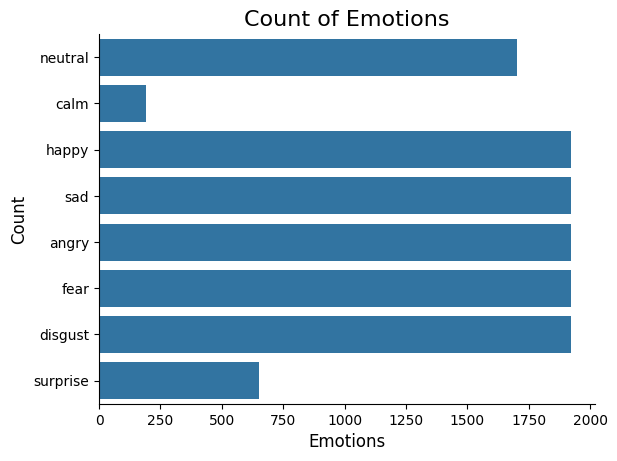

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:




def volume_perturbation(data, low=0.5, high=1.5):
    factor = np.random.uniform(low, high)
    return data * factor

def clipping_distortion(data, clip_percent=0.02):
    threshold = clip_percent * np.max(np.abs(data))
    data = np.clip(data, -threshold, threshold)
    return data

def pink_noise(data):
    # Voss-McCartney algorithm-based pink noise
    uneven = data.shape[0] % 2
    X = np.random.randn(data.shape[0]//2 + 1 + uneven) + 1j * np.random.randn(data.shape[0]//2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)  # Spectral shaping
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    y = y / np.max(np.abs(y))  # Normalize
    return data + 0.005 * y

def salt_and_pepper_audio(data, amount=0.005):
    noisy_data = data.copy()
    num_samples = int(amount * data.shape[0])
    indices = np.random.randint(0, data.shape[0], num_samples)
    for i in indices:
        noisy_data[i] = np.random.choice([np.min(data), np.max(data)])
    return noisy_data

def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=steps)


# ========== Dataset ==========
class EmotionAudioDataset(Dataset):
    def __init__(self, dataframe, processor_name="MIT/ast-finetuned-speech-commands-v2", train=True):
        df = dataframe.copy().dropna().reset_index(drop=True)

        # Encode emotions to integers
        self.label_map = {emotion: i for i, emotion in enumerate(sorted(df["Emotions"].unique()))}
        self.df = df.copy()
        self.df["label"] = self.df["Emotions"].map(self.label_map)
        
        # Stratified split
        train_df, val_df = train_test_split(self.df, test_size=0.2, stratify=self.df["label"], random_state=42)

        
        self.df = train_df if train else val_df
             # Step 2: Augment training set
        augmented_rows_train = []
        for _, row in self.df.iterrows():
            for aug_type in ["original", "noise", "stretch_pitch", "salt_pepper", "pink", "clip", "volume"]:
                augmented_rows_train.append({
                    "Path": row["Path"],
                    "Emotions": row["Emotions"],
                    "label": row["label"],  # <-- ЭТО ВАЖНО
                    "AugType": aug_type
                })
        self.df = pd.DataFrame(augmented_rows_train)

        self.processor = AutoProcessor.from_pretrained(processor_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["Path"]
        label = row["label"]
        aug_type = row["AugType"]

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)
        
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        waveform = waveform.squeeze().numpy()

        # Apply augmentation
        if aug_type == "noise":
            waveform = add_noise(waveform)
        elif aug_type == "stretch_pitch":
            waveform = stretch(waveform)
            waveform = pitch(waveform, sample_rate)
        elif aug_type == "salt_pepper":
            waveform = salt_and_pepper_audio(waveform)
        elif aug_type == "pink":
            waveform = pink_noise(waveform)
        elif aug_type == "clip":
            waveform = clipping_distortion(waveform)
        elif aug_type == "volume":
            waveform = volume_perturbation(waveform)

        # Resample if needed
        if sample_rate != 16000:
            waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)
            sample_rate = 16000

        # Back to tensor
        waveform = torch.tensor(waveform)

        try:
            processed = self.processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                max_length=16000
            )
            input_values = processed.input_values.squeeze(0)
        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)

        return input_values, torch.tensor(label)

# ========== Classifier ==========
class CustomClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=8):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)


class ComplexClassifierHead(nn.Module):
    def __init__(self, input_dim=768, num_classes=8):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)

        # Block 1
        self.fc1 = nn.Linear(input_dim, 512)
        self.act1 = nn.GELU()
        self.drop1 = nn.Dropout(0.3)

        # Block 2
        self.fc2 = nn.Linear(512, 512)
        self.act2 = nn.GELU()
        self.drop2 = nn.Dropout(0.3)

          # Block 3
        self.fc3 = nn.Linear(512,512)
        self.act3 = nn.GELU()
        self.drop3 = nn.Dropout(0.3)

        # Block 4
        self.fc4 = nn.Linear(512,128)
        self.act4 = nn.GELU()
        self.drop4 = nn.Dropout(0.3)

        # Block 5
        self.fc5 = nn.Linear(128, 128)
        self.act5 = nn.GELU()
        self.drop5 = nn.Dropout(0.3)

        # Block 6
        self.fc6 = nn.Linear(128, 128)
        self.act6 = nn.GELU()
        self.drop6 = nn.Dropout(0.3)

        # Output layer
        self.output = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Input normalization
        x = self.norm(x)
        
        # Block 1
        x = self.drop1(self.act1(self.fc1(x)))
        res1 = x

        # Block 2
        x = self.drop2(self.act2(self.fc2(x)))

        # Block 3
        x = self.drop3(self.act3(self.fc3(x)))
        x = x + res1

        # Block 4
        x = self.drop4(self.act4(self.fc4(x)))
        res2 = x

        x = self.drop5(self.act5(self.fc5(x)))

        x = self.drop6(self.act6(self.fc6(x)))
        x = x + res2

        # Output
        return self.softmax(self.output(x))

def save_checkpoint(model, optimizer, epoch, path="checkpoints/checkpoint.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# ========== Training ==========
def train_model(model, train_loader, val_loader, label_map, num_epochs=10, learning_rate=2e-5, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)

    train_labels = train_loader.dataset.df["label"]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # log for saving full metrics
    metrics_log = []

    start_epoch = 0

    ast_unfrozen = False
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):

        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # === Unfreeze AST backbone after epoch 15 ===
        if epoch == 5 and not ast_unfrozen:
            print("🔓 Unfreezing AST backbone...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
            ast_unfrozen = True

        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(input_values=inputs).logits

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                val_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Get full classification report
        target_names = list(label_map.keys())
        report = classification_report(
            all_labels, all_preds,
            target_names=target_names,
            digits=4,
            output_dict=True
        )

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"F1 Score: {f1_weighted:.4f}")
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

        save_checkpoint(model, optimizer, epoch + 1, path=f"checkpoints/epoch_{epoch+1}.pth")

        # Flatten the classification report
        flat_report = {
            f"{label}_{metric}": round(value, 4)
            for label, scores in report.items()
            for metric, value in (scores.items() if isinstance(scores, dict) else [("value", scores)])
        }

        # Save all metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "timestamp": datetime.now().isoformat(),
            "train_loss": round(train_loss, 4),
            "train_accuracy": round(train_acc, 2),
            "val_loss": round(val_loss, 4),
            "val_accuracy": round(val_acc, 2),
            "f1_weighted": round(f1_weighted, 4),
            "f1_macro": round(f1_macro, 4),
            "report": flat_report
        }

        metrics_log.append(epoch_metrics)
        with open("metrics_log.json", "w") as f:
            json.dump(metrics_log, f, indent=2)

    print("\u2705 Training complete!")

    # Plot and save curves
    total_epochs_ran = range(start_epoch + 1, start_epoch + len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs_ran, train_losses, label='Train Loss')
    plt.plot(total_epochs_ran, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(total_epochs_ran, train_accs, label='Train Acc')
    plt.plot(total_epochs_ran, val_accs, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"\u2705 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

# ========== Main ==========
if __name__ == "__main__":



    train_dataset = EmotionAudioDataset(data_path, train=True)
    val_dataset = EmotionAudioDataset(data_path, train=False)


    

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-speech-commands-v2",
        num_labels=len(train_dataset.label_map),
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = False

    # custom_clf = CustomClassifier(model.config.hidden_size, len(train_dataset.label_map))
    # model.classifier = custom_clf

    custom_clf = ComplexClassifierHead(model.config.hidden_size, len(train_dataset.label_map))
    model.classifier = custom_clf

    for param in model.classifier.parameters():
        param.requires_grad = True

    train_model(
    model,
    train_loader,
    val_loader,
    label_map=train_dataset.label_map,
    num_epochs=75, 
    checkpoint_path="checkpoints/epoch_52.pth"
    )

    torch.save(model.state_dict(), "final_model_emotions_with_augmentation_state_dict.pth")
    torch.save(model, "final_model_emotions_with_augmentation.pth")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-speech-commands-v2 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([35]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([35, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/75

Epoch 1/75


Epoch 1, Loss: 1.9332, Accuracy: 25.29%


/home/raf/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raf/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/raf/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Validation Loss: 1.8863, Accuracy: 34.00%
F1 Score: 0.2926
              precision    recall  f1-score   support

       angry     0.3999    0.5410    0.4599      2695
        calm     0.1740    0.9323    0.2933       266
     disgust     0.0000    0.0000    0.0000      2695
        fear     0.3572    0.3280    0.3420      2695
       happy     0.2494    0.0827    0.1243      2695
     neutral     0.3332    0.5424    0.4128      2380
         sad     0.3655    0.3737    0.3695      2695
    surprise     0.3468    0.7473    0.4737       910

    accuracy                         0.3400     17031
   macro avg     0.2782    0.4434    0.3094     17031
weighted avg     0.2849    0.3400    0.2926     17031

✅ Checkpoint saved at epoch 1

Epoch 2/75

Epoch 2/75


Epoch 2, Loss: 1.8257, Accuracy: 36.23%


Validation Loss: 1.8311, Accuracy: 39.41%
F1 Score: 0.3578
              precision    recall  f1-score   support

       angry     0.4866    0.6011    0.5378      2695
        calm     0.2002    0.9699    0.3318       266
     disgust     0.6768    0.0412    0.0776      2695
        fear     0.5073    0.2583    0.3423      2695
       happy     0.3271    0.2212    0.2639      2695
     neutral     0.3626    0.5542    0.4384      2380
         sad     0.3909    0.5098    0.4425      2695
    surprise     0.3880    0.8110    0.5249       910

    accuracy                         0.3941     17031
   macro avg     0.4174    0.4958    0.3699     17031
weighted avg     0.4525    0.3941    0.3578     17031

✅ Checkpoint saved at epoch 2

Epoch 3/75

Epoch 3/75


Epoch 3, Loss: 1.7857, Accuracy: 41.20%


Validation Loss: 1.7999, Accuracy: 43.36%
F1 Score: 0.4036
              precision    recall  f1-score   support

       angry     0.4904    0.7109    0.5804      2695
        calm     0.2013    0.9662    0.3331       266
     disgust     0.7367    0.1340    0.2267      2695
        fear     0.4729    0.3039    0.3700      2695
       happy     0.3726    0.1844    0.2467      2695
     neutral     0.4270    0.5508    0.4811      2380
         sad     0.4211    0.5547    0.4788      2695
    surprise     0.4357    0.8000    0.5641       910

    accuracy                         0.4336     17031
   macro avg     0.4447    0.5256    0.4101     17031
weighted avg     0.4807    0.4336    0.4036     17031

✅ Checkpoint saved at epoch 3

Epoch 4/75

Epoch 4/75


Epoch 4, Loss: 1.7622, Accuracy: 43.58%


Validation Loss: 1.7807, Accuracy: 44.98%
F1 Score: 0.4291
              precision    recall  f1-score   support

       angry     0.5621    0.6516    0.6035      2695
        calm     0.2334    0.9662    0.3760       266
     disgust     0.7108    0.1532    0.2521      2695
        fear     0.5530    0.2827    0.3742      2695
       happy     0.3547    0.3143    0.3333      2695
     neutral     0.4335    0.5571    0.4876      2380
         sad     0.4438    0.5748    0.5009      2695
    surprise     0.3932    0.8253    0.5326       910

    accuracy                         0.4498     17031
   macro avg     0.4606    0.5407    0.4325     17031
weighted avg     0.5005    0.4498    0.4291     17031

✅ Checkpoint saved at epoch 4

Epoch 5/75

Epoch 5/75


Epoch 5, Loss: 1.7439, Accuracy: 45.46%


Validation Loss: 1.7680, Accuracy: 46.38%
F1 Score: 0.4474
              precision    recall  f1-score   support

       angry     0.5814    0.6571    0.6170      2695
        calm     0.2180    0.9737    0.3563       266
     disgust     0.5926    0.2126    0.3129      2695
        fear     0.5625    0.2720    0.3667      2695
       happy     0.3887    0.3150    0.3480      2695
     neutral     0.4407    0.5992    0.5078      2380
         sad     0.4588    0.5718    0.5091      2695
    surprise     0.4273    0.8209    0.5621       910

    accuracy                         0.4638     17031
   macro avg     0.4588    0.5528    0.4475     17031
weighted avg     0.4967    0.4638    0.4474     17031

✅ Checkpoint saved at epoch 5

Epoch 6/75
🔓 Unfreezing AST backbone...

Epoch 6/75


Epoch 6, Loss: 1.6533, Accuracy: 55.57%


Validation Loss: 1.6780, Accuracy: 55.49%
F1 Score: 0.5468
              precision    recall  f1-score   support

       angry     0.6940    0.7592    0.7251      2695
        calm     0.1965    1.0000    0.3284       266
     disgust     0.7634    0.2909    0.4213      2695
        fear     0.6922    0.4263    0.5277      2695
       happy     0.5709    0.3614    0.4426      2695
     neutral     0.4614    0.8101    0.5879      2380
         sad     0.5855    0.5562    0.5705      2695
    surprise     0.5034    0.8835    0.6414       910

    accuracy                         0.5549     17031
   macro avg     0.5584    0.6360    0.5306     17031
weighted avg     0.6176    0.5549    0.5468     17031

✅ Checkpoint saved at epoch 6

Epoch 7/75

Epoch 7/75


Epoch 7, Loss: 1.5558, Accuracy: 66.97%


Validation Loss: 1.6375, Accuracy: 60.55%
F1 Score: 0.6071
              precision    recall  f1-score   support

       angry     0.7708    0.7039    0.7358      2695
        calm     0.2530    0.9474    0.3994       266
     disgust     0.6245    0.4393    0.5158      2695
        fear     0.5872    0.5161    0.5494      2695
       happy     0.5562    0.6078    0.5809      2695
     neutral     0.6619    0.6458    0.6538      2380
         sad     0.6043    0.5989    0.6016      2695
    surprise     0.5828    0.8780    0.7006       910

    accuracy                         0.6055     17031
   macro avg     0.5801    0.6672    0.5921     17031
weighted avg     0.6249    0.6055    0.6071     17031

✅ Checkpoint saved at epoch 7

Epoch 8/75

Epoch 8/75


Epoch 8, Loss: 1.5000, Accuracy: 73.66%


Validation Loss: 1.6331, Accuracy: 61.57%
F1 Score: 0.6146
              precision    recall  f1-score   support

       angry     0.7216    0.7673    0.7438      2695
        calm     0.3242    0.9323    0.4811       266
     disgust     0.6047    0.4813    0.5360      2695
        fear     0.5997    0.4998    0.5452      2695
       happy     0.6164    0.5599    0.5868      2695
     neutral     0.5789    0.7029    0.6349      2380
         sad     0.5848    0.6104    0.5973      2695
    surprise     0.8147    0.7681    0.7907       910

    accuracy                         0.6157     17031
   macro avg     0.6056    0.6653    0.6145     17031
weighted avg     0.6243    0.6157    0.6146     17031

✅ Checkpoint saved at epoch 8

Epoch 9/75

Epoch 9/75


Epoch 9, Loss: 1.4657, Accuracy: 77.66%


Validation Loss: 1.6351, Accuracy: 61.16%
F1 Score: 0.6077
              precision    recall  f1-score   support

       angry     0.7236    0.7596    0.7411      2695
        calm     0.3279    0.9023    0.4810       266
     disgust     0.5267    0.5570    0.5414      2695
        fear     0.7100    0.3889    0.5025      2695
       happy     0.6429    0.5317    0.5820      2695
     neutral     0.5949    0.7084    0.6467      2380
         sad     0.5670    0.6278    0.5959      2695
    surprise     0.7010    0.8451    0.7663       910

    accuracy                         0.6116     17031
   macro avg     0.5992    0.6651    0.6071     17031
weighted avg     0.6274    0.6116    0.6077     17031

✅ Checkpoint saved at epoch 9

Epoch 10/75

Epoch 10/75


Epoch 10, Loss: 1.4437, Accuracy: 80.28%


Validation Loss: 1.6273, Accuracy: 61.68%
F1 Score: 0.6149
              precision    recall  f1-score   support

       angry     0.7108    0.7751    0.7416      2695
        calm     0.2979    0.9286    0.4511       266
     disgust     0.6394    0.4705    0.5421      2695
        fear     0.6311    0.4939    0.5541      2695
       happy     0.5837    0.5744    0.5790      2695
     neutral     0.6204    0.6887    0.6527      2380
         sad     0.5871    0.6015    0.5942      2695
    surprise     0.6819    0.8363    0.7512       910

    accuracy                         0.6168     17031
   macro avg     0.5940    0.6711    0.6083     17031
weighted avg     0.6266    0.6168    0.6149     17031

✅ Checkpoint saved at epoch 10

Epoch 11/75

Epoch 11/75


Epoch 11, Loss: 1.4285, Accuracy: 81.98%


Validation Loss: 1.6340, Accuracy: 61.36%
F1 Score: 0.6107
              precision    recall  f1-score   support

       angry     0.6693    0.7944    0.7265      2695
        calm     0.2999    0.9323    0.4538       266
     disgust     0.6655    0.4304    0.5228      2695
        fear     0.5546    0.5803    0.5672      2695
       happy     0.6456    0.5069    0.5679      2695
     neutral     0.6316    0.6786    0.6542      2380
         sad     0.5920    0.5981    0.5951      2695
    surprise     0.7122    0.8187    0.7618       910

    accuracy                         0.6136     17031
   macro avg     0.5963    0.6675    0.6061     17031
weighted avg     0.6258    0.6136    0.6107     17031

✅ Checkpoint saved at epoch 11

Epoch 12/75

Epoch 12/75


Epoch 12, Loss: 1.4166, Accuracy: 83.46%


Validation Loss: 1.6374, Accuracy: 62.12%
F1 Score: 0.6170
              precision    recall  f1-score   support

       angry     0.6067    0.8442    0.7060      2695
        calm     0.3545    0.6917    0.4688       266
     disgust     0.6232    0.5106    0.5613      2695
        fear     0.5905    0.5510    0.5701      2695
       happy     0.6493    0.5091    0.5707      2695
     neutral     0.6241    0.6773    0.6496      2380
         sad     0.6521    0.5696    0.6080      2695
    surprise     0.7482    0.8132    0.7794       910

    accuracy                         0.6212     17031
   macro avg     0.6061    0.6458    0.6142     17031
weighted avg     0.6267    0.6212    0.6170     17031

✅ Checkpoint saved at epoch 12

Epoch 13/75

Epoch 13/75


Epoch 13, Loss: 1.4058, Accuracy: 84.75%


Validation Loss: 1.6250, Accuracy: 62.93%
F1 Score: 0.6278
              precision    recall  f1-score   support

       angry     0.7280    0.7447    0.7362      2695
        calm     0.3779    0.8609    0.5252       266
     disgust     0.6231    0.5043    0.5574      2695
        fear     0.6331    0.4731    0.5415      2695
       happy     0.6001    0.6204    0.6101      2695
     neutral     0.6625    0.6748    0.6686      2380
         sad     0.5477    0.6876    0.6097      2695
    surprise     0.8136    0.7868    0.8000       910

    accuracy                         0.6293     17031
   macro avg     0.6233    0.6691    0.6311     17031
weighted avg     0.6376    0.6293    0.6278     17031

✅ Checkpoint saved at epoch 13

Epoch 14/75

Epoch 14/75


Epoch 14, Loss: 1.3970, Accuracy: 85.68%


Validation Loss: 1.6365, Accuracy: 61.04%
F1 Score: 0.6077
              precision    recall  f1-score   support

       angry     0.6960    0.7536    0.7237      2695
        calm     0.3792    0.8910    0.5320       266
     disgust     0.6275    0.4712    0.5382      2695
        fear     0.5745    0.4865    0.5268      2695
       happy     0.5452    0.6241    0.5820      2695
     neutral     0.7079    0.5887    0.6428      2380
         sad     0.5973    0.6263    0.6115      2695
    surprise     0.6006    0.8527    0.7048       910

    accuracy                         0.6104     17031
   macro avg     0.5910    0.6618    0.6077     17031
weighted avg     0.6181    0.6104    0.6077     17031

✅ Checkpoint saved at epoch 14

Epoch 15/75

Epoch 15/75


Epoch 15, Loss: 1.3899, Accuracy: 86.56%


Validation Loss: 1.6220, Accuracy: 62.57%
F1 Score: 0.6246
              precision    recall  f1-score   support

       angry     0.7402    0.7243    0.7322      2695
        calm     0.3522    0.8872    0.5043       266
     disgust     0.6053    0.5087    0.5528      2695
        fear     0.6075    0.5380    0.5706      2695
       happy     0.6030    0.6030    0.6030      2695
     neutral     0.6078    0.7143    0.6568      2380
         sad     0.6218    0.5759    0.5980      2695
    surprise     0.7103    0.8462    0.7723       910

    accuracy                         0.6257     17031
   macro avg     0.6060    0.6747    0.6237     17031
weighted avg     0.6312    0.6257    0.6246     17031

✅ Checkpoint saved at epoch 15

Epoch 16/75

Epoch 16/75


Epoch 16, Loss: 1.3856, Accuracy: 87.14%


Validation Loss: 1.6266, Accuracy: 62.49%
F1 Score: 0.6218
              precision    recall  f1-score   support

       angry     0.6434    0.8215    0.7216      2695
        calm     0.3710    0.7782    0.5024       266
     disgust     0.5869    0.4935    0.5362      2695
        fear     0.5705    0.5662    0.5683      2695
       happy     0.6232    0.5481    0.5832      2695
     neutral     0.6824    0.6634    0.6728      2380
         sad     0.6468    0.5763    0.6095      2695
    surprise     0.7525    0.8319    0.7902       910

    accuracy                         0.6249     17031
   macro avg     0.6096    0.6599    0.6230     17031
weighted avg     0.6273    0.6249    0.6218     17031

✅ Checkpoint saved at epoch 16

Epoch 17/75

Epoch 17/75


Epoch 17, Loss: 1.3785, Accuracy: 87.95%


Validation Loss: 1.6269, Accuracy: 62.57%
F1 Score: 0.6224
              precision    recall  f1-score   support

       angry     0.6956    0.7529    0.7231      2695
        calm     0.3651    0.7932    0.5000       266
     disgust     0.6548    0.4490    0.5327      2695
        fear     0.6051    0.5299    0.5650      2695
       happy     0.6099    0.5848    0.5971      2695
     neutral     0.5943    0.7336    0.6566      2380
         sad     0.6001    0.6304    0.6149      2695
    surprise     0.7764    0.8319    0.8032       910

    accuracy                         0.6257     17031
   macro avg     0.6127    0.6632    0.6241     17031
weighted avg     0.6311    0.6257    0.6224     17031

✅ Checkpoint saved at epoch 17

Epoch 18/75

Epoch 18/75


Epoch 18, Loss: 1.3749, Accuracy: 88.36%


Validation Loss: 1.6262, Accuracy: 62.94%
F1 Score: 0.6269
              precision    recall  f1-score   support

       angry     0.6847    0.7766    0.7277      2695
        calm     0.3654    0.7707    0.4958       266
     disgust     0.6252    0.4902    0.5495      2695
        fear     0.5952    0.5325    0.5621      2695
       happy     0.6491    0.5655    0.6044      2695
     neutral     0.6478    0.6668    0.6571      2380
         sad     0.5837    0.6705    0.6241      2695
    surprise     0.7508    0.8209    0.7843       910

    accuracy                         0.6294     17031
   macro avg     0.6127    0.6617    0.6256     17031
weighted avg     0.6329    0.6294    0.6269     17031

✅ Checkpoint saved at epoch 18

Epoch 19/75

Epoch 19/75


Epoch 19, Loss: 1.3710, Accuracy: 88.84%


Validation Loss: 1.6311, Accuracy: 62.15%
F1 Score: 0.6192
              precision    recall  f1-score   support

       angry     0.7261    0.7525    0.7391      2695
        calm     0.3792    0.8496    0.5244       266
     disgust     0.6305    0.4490    0.5245      2695
        fear     0.6037    0.4816    0.5358      2695
       happy     0.5851    0.6505    0.6161      2695
     neutral     0.7030    0.6265    0.6625      2380
         sad     0.5267    0.6813    0.5941      2695
    surprise     0.7649    0.8154    0.7894       910

    accuracy                         0.6215     17031
   macro avg     0.6149    0.6633    0.6232     17031
weighted avg     0.6312    0.6215    0.6192     17031

✅ Checkpoint saved at epoch 19

Epoch 20/75

Epoch 20/75


Epoch 20, Loss: 1.3689, Accuracy: 89.07%


Validation Loss: 1.6267, Accuracy: 62.67%
F1 Score: 0.6256
              precision    recall  f1-score   support

       angry     0.7304    0.7570    0.7434      2695
        calm     0.3886    0.8459    0.5325       266
     disgust     0.6275    0.4712    0.5382      2695
        fear     0.5947    0.5429    0.5676      2695
       happy     0.6019    0.6007    0.6013      2695
     neutral     0.7085    0.6076    0.6542      2380
         sad     0.5394    0.6987    0.6088      2695
    surprise     0.7629    0.7989    0.7805       910

    accuracy                         0.6267     17031
   macro avg     0.6192    0.6654    0.6283     17031
weighted avg     0.6354    0.6267    0.6256     17031

✅ Checkpoint saved at epoch 20

Epoch 21/75

Epoch 21/75


Epoch 21, Loss: 1.3630, Accuracy: 89.72%


Validation Loss: 1.6308, Accuracy: 62.53%
F1 Score: 0.6231
              precision    recall  f1-score   support

       angry     0.7708    0.7076    0.7379      2695
        calm     0.4518    0.7218    0.5557       266
     disgust     0.6723    0.4263    0.5218      2695
        fear     0.5489    0.5688    0.5587      2695
       happy     0.5659    0.6512    0.6056      2695
     neutral     0.6334    0.6933    0.6620      2380
         sad     0.5904    0.6364    0.6125      2695
    surprise     0.7341    0.8220    0.7755       910

    accuracy                         0.6253     17031
   macro avg     0.6209    0.6534    0.6287     17031
weighted avg     0.6330    0.6253    0.6231     17031

✅ Checkpoint saved at epoch 21

Epoch 22/75

Epoch 22/75


Epoch 22, Loss: 1.3625, Accuracy: 89.90%


Validating:  16%|███████▋                                         | 83/533 [00:46<03:53,  1.93it/s, acc=63.3, loss=1.89]